# Análisis _grid search_
En este notebook se analizan los resultados obtenidos tras el _grid search_ realizado de los cuatro parámetros que controlan la evolución de los drivings.

In [1]:
from src.ahs_utils import show_register, show_drive_and_local_detuning, show_final_avg_density
from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.ahs.local_detuning import LocalDetuning

import ast

from src.drivings_aitor import Drivings2
from src.aitor_utils import Graph_gen, C_from_gr, get_blockade_configurations2

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx

from collections import Counter
import itertools
from tqdm import tqdm
import time

from ortools.linear_solver import pywraplp

import gurobipy as gp
from gurobipy import GRB

from io import BytesIO
import imageio.v2 as imageio

from scipy import optimize

import qutip as qt

simulator = LocalSimulator("braket_ahs")

**Cargamos los resultados del gridsearch**

In [2]:
df = pd.read_csv('results_gridsearch.csv')

In [3]:
# see all values in 'seed_list' are the same
if len(df['seed_list'].unique()) == 1:
    print('Todas las listas de semillas son iguales')
    seed_list = [int(x) for x in eval(df['seed_list'].unique()[0])]
else:
    print('Hay semillas diferentes!')
    raise ValueError

Todas las listas de semillas son iguales


In [4]:
df.head()

,cost,param0,param1,param2,param3,ar_list,seed_list
0,0.002375,0.0,0.0,0.0,0.000000,"(0.0010715957884830304, 0.0017296236791694984,...","(np.int64(4), np.int64(5), np.int64(13), np.in..."
1,0.036523,0.0,0.0,0.0,0.071429,"(0.03588753602729253, 0.03298605635543472, 0.0...","(np.int64(4), np.int64(5), np.int64(13), np.in..."
2,0.592204,0.0,0.0,0.0,0.142857,"(0.6691307217222517, 0.5063328091206822, 0.661...","(np.int64(4), np.int64(5), np.int64(13), np.in..."
3,0.493937,0.0,0.0,0.0,0.214286,"(0.5548659902358682, 0.4101692238769079, 0.518...","(np.int64(4), np.int64(5), np.int64(13), np.in..."
4,0.460893,0.0,0.0,0.0,0.285714,"(0.643415693194518, 0.2536281993449916, 0.4178...","(np.int64(4), np.int64(5), np.int64(13), np.in..."


## Mostramos el mejor resultado

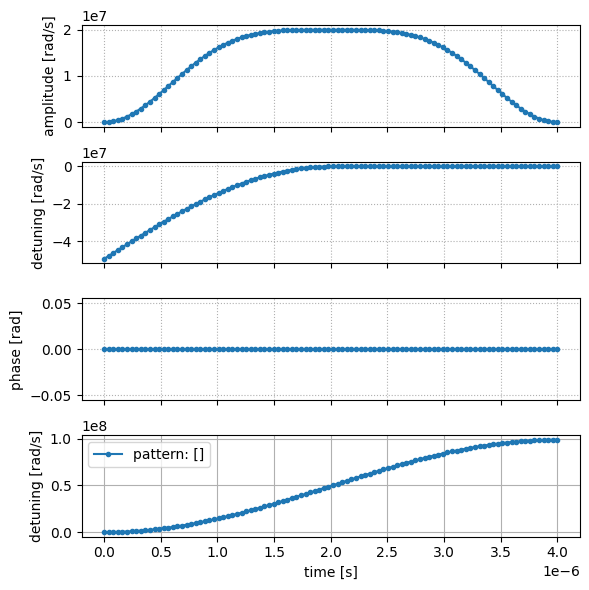

In [ ]:
# Para este caso utilizamos los siguientes valores máximos de los drivings
time_max = 4 # microsegundos
Omega_max = 20 * 1e6  # RAD/S
Delta_max = 9.9007768e7  # RAD/S
Delta_local_max = 9.9007768e7  # RAD/S

Delta_0 = list(df[df['cost'] == df['cost'].max()][["param0", "param1", "param2", "param3"]].values[0])

og_weights = []
drive, local_detuning_drive, delta_local_array, time = Drivings2(time_max, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0)

show_drive_and_local_detuning(drive , local_detuning_drive)

In [48]:
print(f'Mejor resultado: AR medio = {df["cost"].max()}')
print(f'Parámetros: {Delta_0}')

Mejor resultado: AR medio = 0.9942436753987676
Parámetros: [np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(0.5)]


Vemos que este resultado es muy similar al que hemos encontrado mediante el BO y el COBYLA

Gráfica AR vs e_gap

In [49]:
# Obtener los valores de AR de cada grafo simulado
ar_list = list(ast.literal_eval(df[df['cost'] == df['cost'].max()][['ar_list']].values[0][0]))

# Calcular el gap para cada semilla
e_gap_list = []

for seed in seed_list:
    np.random.seed(seed)
    graph, atoms = Graph_gen(7, 4, 3, 5e-6)
    positions = np.array(list(nx.get_node_attributes(graph, 'pos').values()))
    og_weights = nx.get_node_attributes(graph, 'weight')
    
    # Calcular el espectro del grafo
    conf = get_blockade_configurations2(positions, 7.2e-6)
    espectro = pd.DataFrame(conf, columns=['bitstring'])
    espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, og_weights, graph.nodes()))
    espectro = espectro.sort_values('energia', ascending=True)

    e_gap = espectro['energia'].values[1] - espectro['energia'].values[0]
    e_gap_list.append(e_gap)

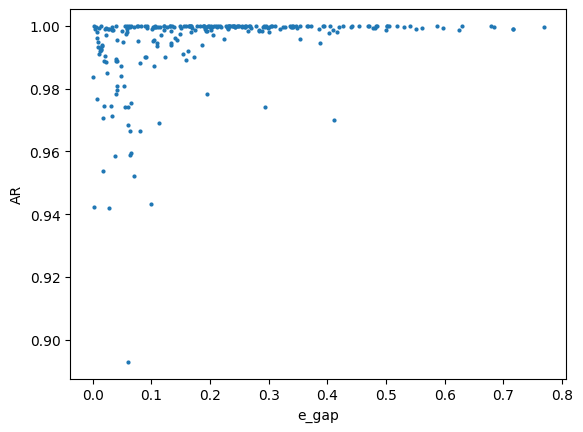

In [50]:
plt.plot(e_gap_list, ar_list, 'o',markersize=2)
plt.xlabel('e_gap')
plt.ylabel('AR')
plt.show()

## Efecto de cada parámetro de manera individual

In [6]:
nombres = {
    'param0': r'$a_{\text{global}}$',
    'param1': r'$b_{\text{global}}$',
    'param2': r'$a_{\text{local}}$',
    'param3': r'$b_{\text{local}}$',
    'cost': 'AR',
}

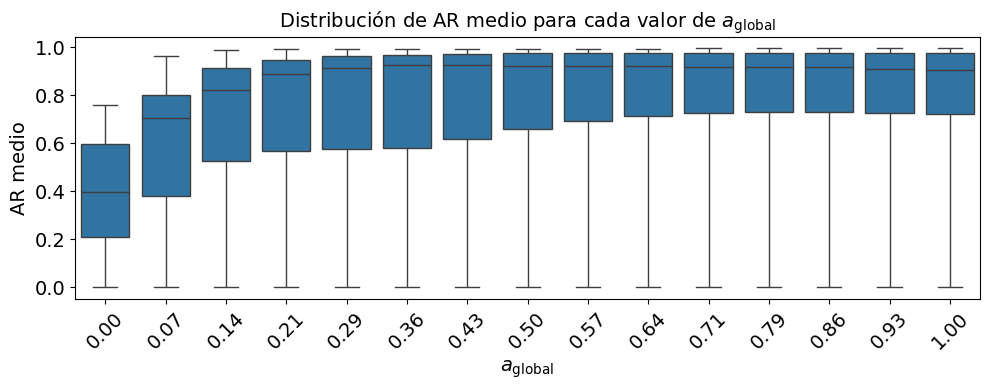

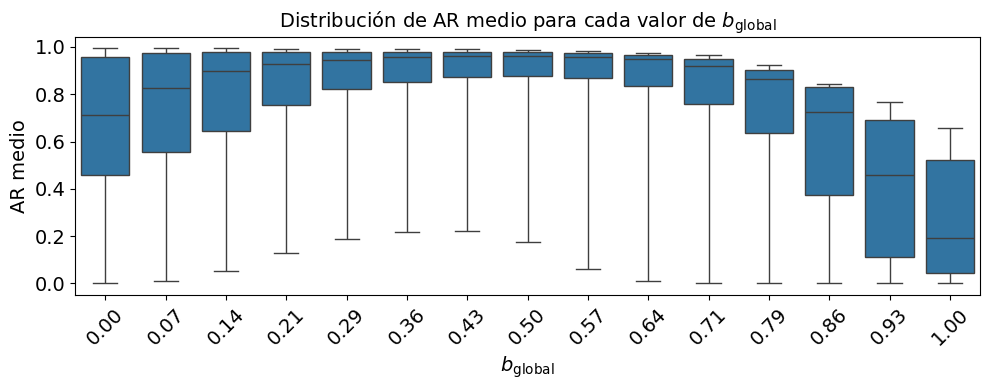

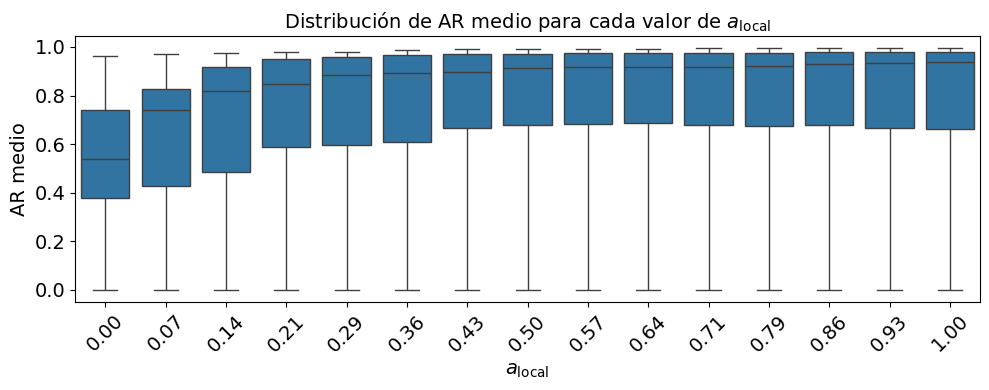

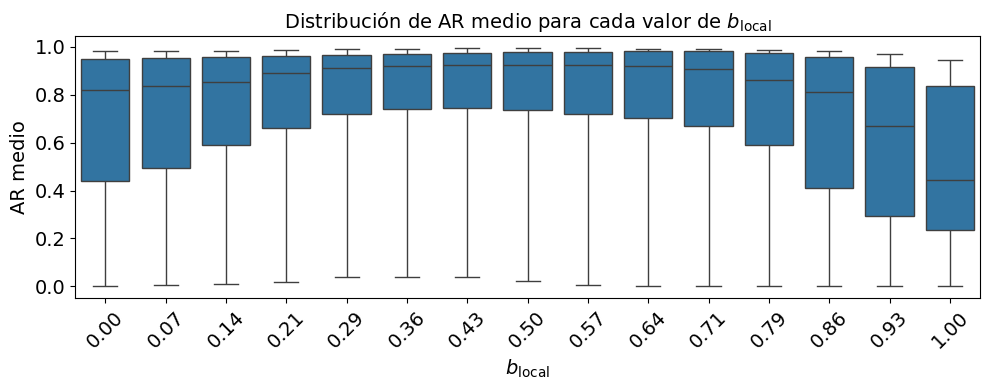

In [ ]:
df2 = df.copy()
for param in ["param0", "param1", "param2", "param3"]:
    df2[param] = df2[param].apply(lambda x: "{:.2f}".format(x))
    df2 = df2.sort_values(param)
    fig, ax = plt.subplots(figsize=(10, 4))  # Crea figura y eje correctamente
    sns.boxplot(data=df2, x=param, y="cost", whis=40, ax=ax)
    # sns.violinplot(data=df, x=param, y="cost", ax=ax)
    # ax.hlines(1, 0, 15, 'red', linewidth=1)
    
    ax.set_title(f"Distribución de AR medio para cada valor de {nombres[param]}", fontsize=14)
    ax.set_xlabel(nombres[param], fontsize=14)
    ax.set_ylabel("AR medio", fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()


## Efecto interación a pares

In [15]:
# Lista de combinaciones de parámetros a comparar
param_pairs = [("param0", "param1"), ("param0", "param2"),
               ("param0", "param3"), ("param1", "param2"),
               ("param1", "param3"), ("param2", "param3")]

df_rounded=df.copy()
df_rounded["param0"] = df_rounded["param0"].round(2)
df_rounded["param1"] = df_rounded["param1"].round(2)
df_rounded["param2"] = df_rounded["param2"].round(2)
df_rounded["param3"] = df_rounded["param3"].round(2)


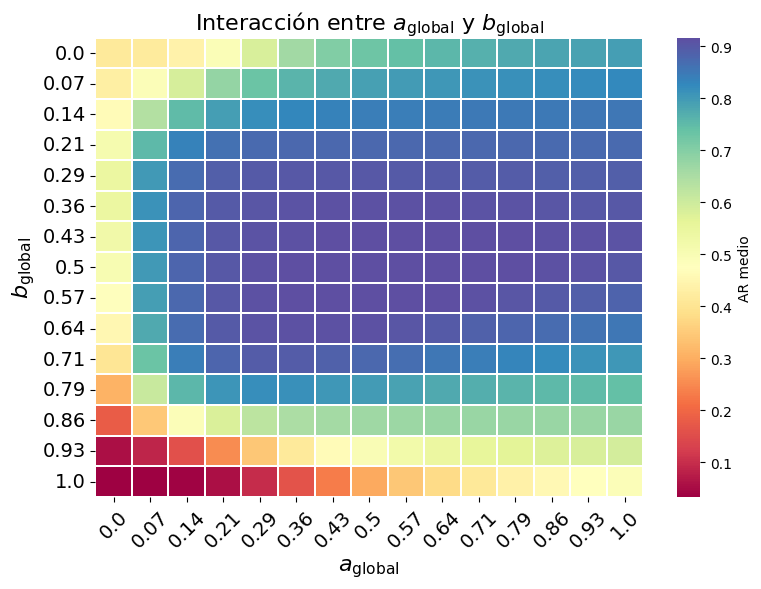

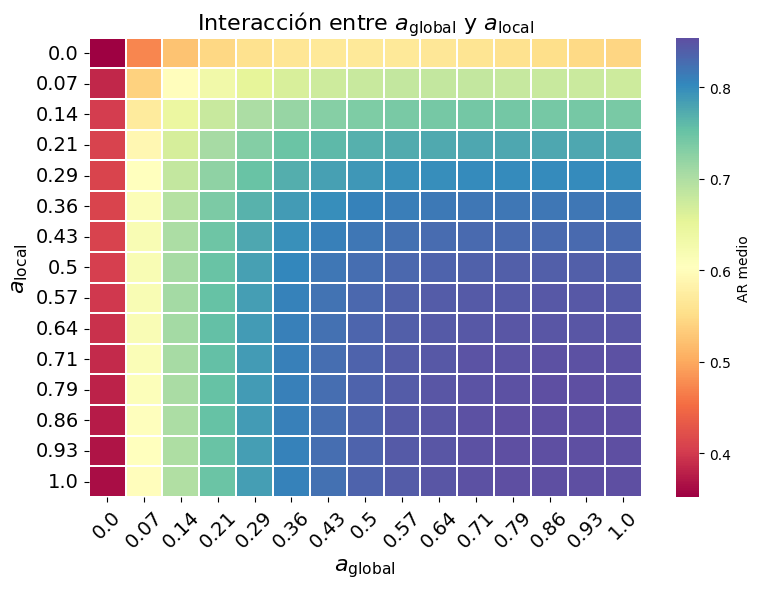

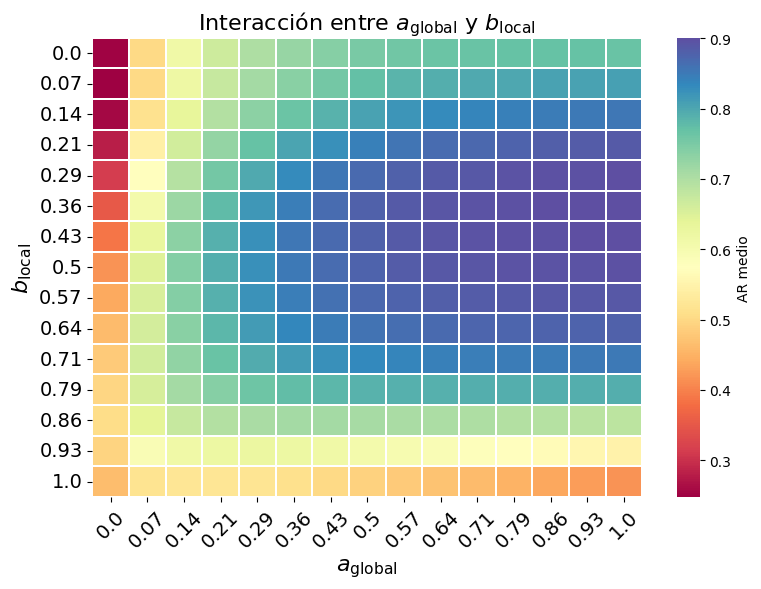

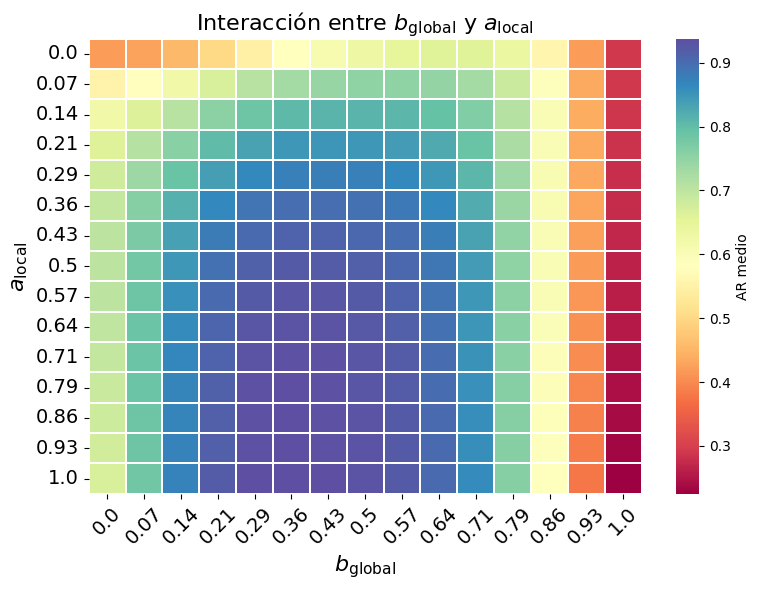

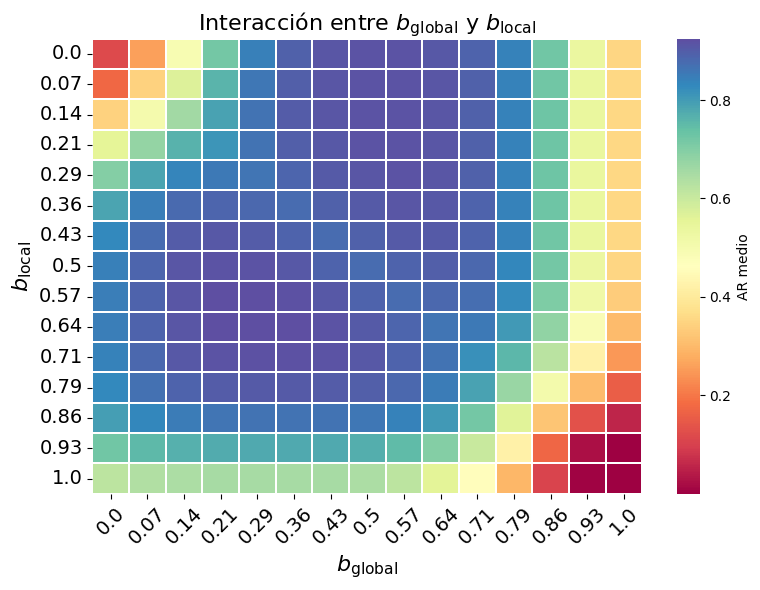

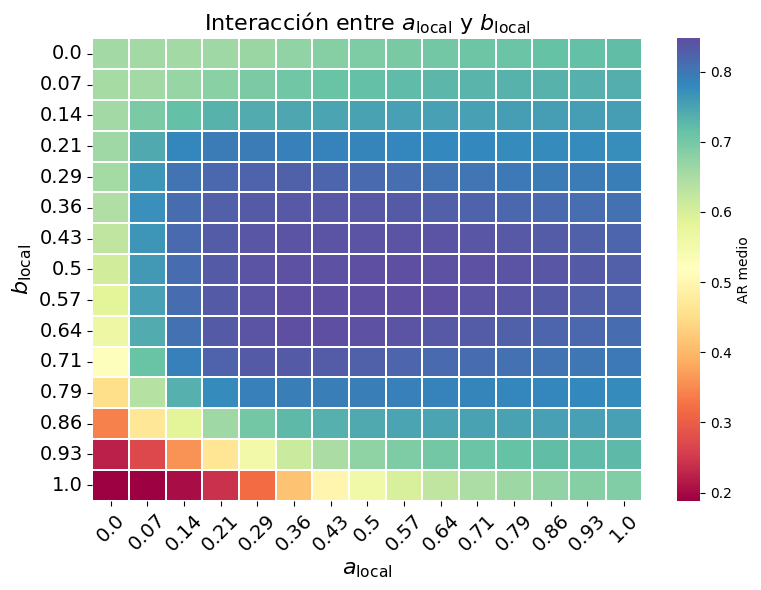

In [68]:
# Graficar un mapa de calor para cada combinación

for x_param, y_param in param_pairs:
    pivot_table = df_rounded.pivot_table(values="cost", index=y_param, columns=x_param, aggfunc="mean")

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, cmap="Spectral" , cbar_kws={"label": "AR medio"}, linewidths=0.1)
    plt.title(f"Interacción entre {nombres[x_param]} y {nombres[y_param]}", fontsize=16)
    plt.xlabel(nombres[x_param], fontsize=16)
    plt.ylabel(nombres[y_param], fontsize=16)
    # Aumentar el tamaño de las etiquetas
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)

    plt.tight_layout()

    plt.savefig(f"figuras/heatmap_{x_param}_{y_param}.png", dpi=300)


In [5]:
import plotly.graph_objects as go
import numpy as np

# Suponemos que ya tienes el DataFrame df
# Seleccionar los parámetros a visualizar
x_param = "param1"
y_param = "param3"

# Crear tabla pivote
pivot = df.pivot_table(values="cost", index=y_param, columns=x_param, aggfunc="mean")
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values

# Crear figura 3D interactiva
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Spectral')])

fig.update_layout(
    title=f'Superficie 3D de {nombres[x_param]} vs {y_param}',
    scene=dict(
        xaxis_title=x_param,
        yaxis_title=y_param,
        zaxis_title='cost'
    ),
    width=800,
    height=700
)

fig.show()


NameError: name 'nombres' is not defined

## Análisis de multicolinealidad

In [15]:
def var1(ar_list):
    varianza = 0
    for ar in ar_list:
        varianza += (ar - 1)**2
    return varianza

ar_list_v2 = []
df_filtered = df[df['cost'] > 0.9]
for i in range(len(df_filtered)):
    ar_list_v2.append([float(x) for x in eval(df_filtered['ar_list'].values[i])])

In [16]:
df_filtered['desviacion'] = [var1(x) for x in ar_list_v2]

C:\Users\aitoo\AppData\Local\Temp\ipykernel_18600\1455151253.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



De los mejores resultados, el que menor varianza tiene es:
AR medio = 0.994141636772804
Parámetros = [1.         0.         0.92857143 0.42857143]
Desviación = 0.044795621638820886


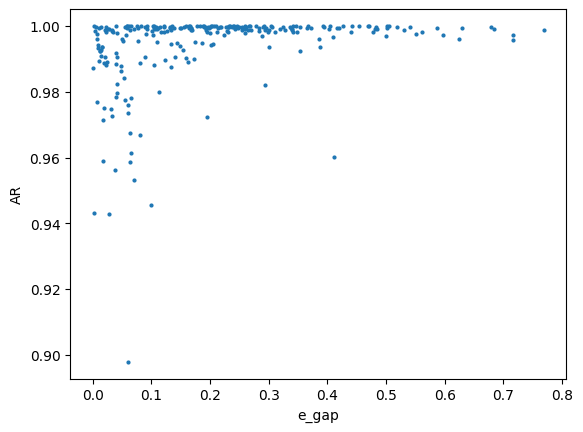

In [17]:
df_filtered = df_filtered.sort_values('desviacion', ascending=True)
ar_list = df_filtered['ar_list'].values[0]
ar_list = list(ast.literal_eval(df_filtered[['ar_list']].values[0][0]))
print('De los mejores resultados, el que menor varianza tiene es:')
print(f'AR medio = {df_filtered["cost"].values[0]}')
print(f'Parámetros = {df_filtered[["param0", "param1", "param2", "param3"]].values[0]}')
print(f'Desviación = {df_filtered["desviacion"].values[0]}')


plt.plot(e_gap_list, ar_list, 'o',markersize=2)
plt.xlabel('e_gap')
plt.ylabel('AR')
plt.show()

De los mejores resultados, el que mayor AR medio tiene es:
AR medio = 0.9942436753987676
Parámetros = [1.  0.  1.  0.5]
Desviación = 0.047699393768816864


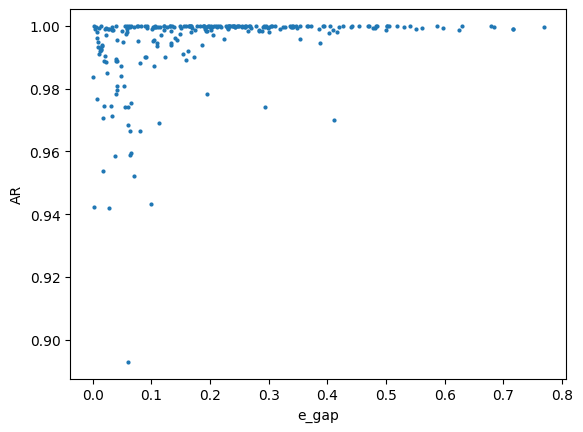

In [18]:
df_filtered = df_filtered.sort_values('cost', ascending=False)
ar_list = df_filtered['ar_list'].values[0]
ar_list = list(ast.literal_eval(df_filtered[['ar_list']].values[0][0]))
print('De los mejores resultados, el que mayor AR medio tiene es:')
print(f'AR medio = {df_filtered["cost"].values[0]}')
print(f'Parámetros = {df_filtered[["param0", "param1", "param2", "param3"]].values[0]}')
print(f'Desviación = {df_filtered["desviacion"].values[0]}')


plt.plot(e_gap_list, ar_list, 'o',markersize=2)
plt.xlabel('e_gap')
plt.ylabel('AR')
plt.show()

## Ajustar modelos

In [8]:
from sklearn.model_selection import train_test_split

# Parámetros como entrada
X = df[["param0", "param1", "param2", "param3"]]

# Coste como variable objetivo
y = df["cost"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random Forest**

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Crear el modelo
rf = RandomForestRegressor(n_estimators=180, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=180, random_state=42)

In [10]:
# Evaluar el modelo
y_pred = rf.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

R2: 0.9980
MAE: 0.0048


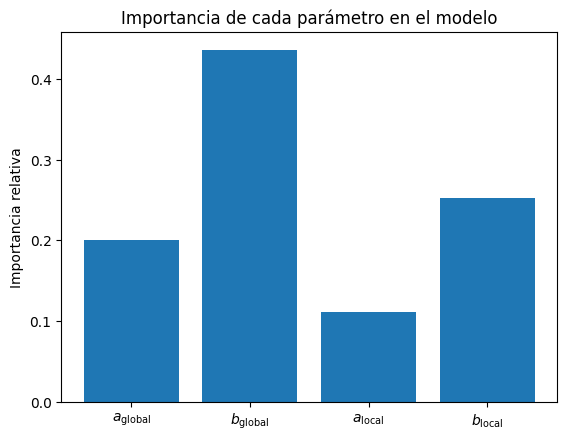

In [13]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
params = X.columns

plt.bar([nombres[i] for i in params], importances)
plt.title("Importancia de cada parámetro en el modelo")
plt.ylabel("Importancia relativa")
plt.show()


**Residuos en función de los parámetros**

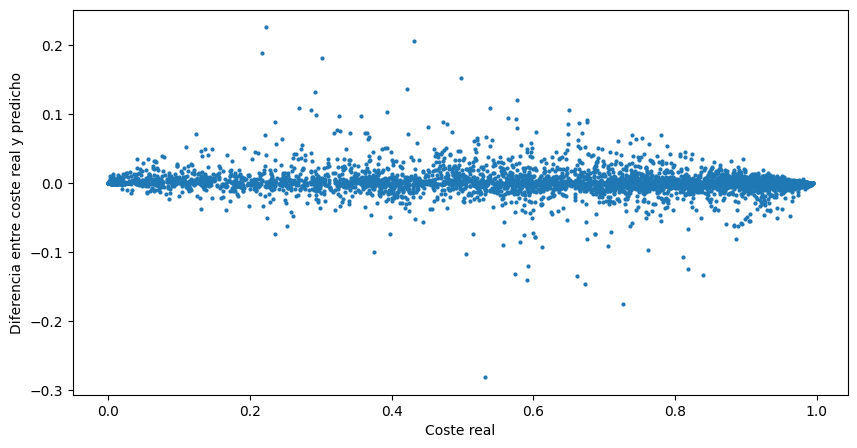

In [8]:
pred_t = rf.predict(X_test)
diff_cost = pred_t - y_test

plt.figure(figsize=(10, 5))
plt.plot(y_test, diff_cost, 'o', markersize=2)
plt.xlabel('Coste real')
plt.ylabel('Diferencia entre coste real y predicho')
plt.show()

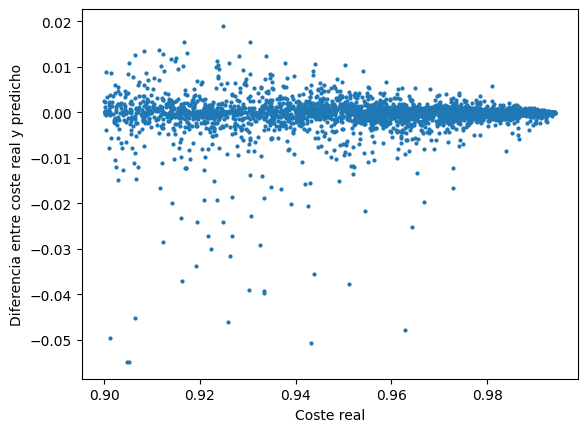

In [9]:
coste_alto = y_test > 0.9
plt.plot(y_test[coste_alto], diff_cost[coste_alto], 'o', markersize=2)
plt.xlabel('Coste real')
plt.ylabel('Diferencia entre coste real y predicho')
plt.show()

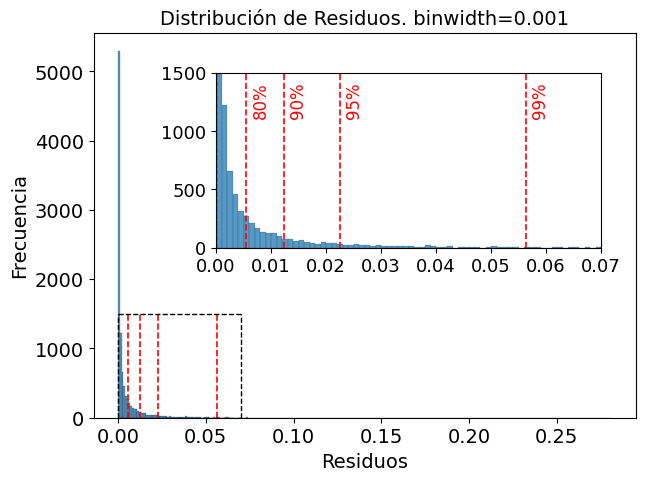

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparar datos
data = abs(diff_cost)

# Calcular percentiles relevantes
percentiles = [80, 90, 95, 99]
percentile_values = np.percentile(data, percentiles)

# Crear la figura principal
fig, ax = plt.subplots(figsize=(7, 5))

# Graficar histograma con seaborn en el eje principal
sns.histplot(data, binwidth=0.001, ax=ax)

# Configurar etiquetas y título
ax.set_xlabel('Residuos', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
ax.set_title(f"Distribución de Residuos. binwidth=0.001", fontsize=14)

# Eje derecho de porcentaje (principal)
# ax_right = ax.twinx()
# ax_right.set_ylabel("Porcentaje (%)")
# ax_right.set_ylim(ax.get_ylim())

# total = len(data)
yticks_main = ax.get_yticks()
# percentages_main = [(y / total) * 100 for y in yticks_main]
# ax_right.set_yticks(yticks_main)
# ax_right.set_yticklabels([f"{p:.1f}%" for p in percentages_main])

# ---------------------- ZOOM ----------------------
ax_inset = fig.add_axes([0.3, 0.45, 0.55, 0.35])  # [x, y, width, height]
sns.histplot(data, binwidth=0.001, ax=ax_inset)

# Configuración del zoom
x_min, x_max = 0.0, 0.07
y_max = 1500
ax_inset.set_xlim(x_min, x_max)
ax_inset.set_ylim(0, y_max)
ax_inset.axvline(0, color='black', linestyle='dashed', linewidth=1)

# Añadir líneas verticales de percentiles en el zoom (solo las que estén en rango)
for p, val in zip(percentiles, percentile_values):
    if x_min < val < x_max:
        ax_inset.axvline(val, color='red', linestyle='--', linewidth=1.2)
        ax_inset.text(val+0.001, y_max * 0.95, f'{p}%', rotation=90,
                      verticalalignment='top', color='red', fontsize=12)

# Limpiar etiquetas
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")

# Fondo blanco opaco
ax_inset.patch.set_facecolor('white')
ax_inset.patch.set_alpha(1.0)

# Eje derecho de porcentaje en el zoom
# ax_inset_right = ax_inset.twinx()
# ax_inset_right.set_ylabel("")
# ax_inset_right.set_ylim(ax_inset.get_ylim())

# yticks_zoom = ax_inset.get_yticks()
# percentages_zoom = [(y / total) * 100 for y in yticks_zoom]
# ax_inset_right.set_yticks(yticks_zoom)
# ax_inset_right.set_yticklabels([f"{p:.2f}%" for p in percentages_zoom])

# Añadir líneas verticales para los percentiles
yticks_main = ax.get_yticks()
for p, val in zip(percentiles, percentile_values):
    ax.axvline(x=val, ymin=0, ymax=y_max/5500, color='red', linestyle='--', linewidth=1.2)
#     ax.text(val*1.1, ax.get_ylim()[1]*0.95, f'{p}%', rotation=90,
#             verticalalignment='top', color='red', fontsize=8)

# Añadir marco de líneas intermitentes en la zona de zoom
ax.plot([x_min, x_max], [0, 0], 'k--', linewidth=1)
ax.plot([x_min, x_max], [y_max, y_max], 'k--', linewidth=1)
ax.plot([x_min, x_min], [0, y_max], 'k--', linewidth=1)
ax.plot([x_max, x_max], [0, y_max], 'k--', linewidth=1)

# Aumentar el tamaño de las etiquetas
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax_inset.tick_params(axis='x', labelsize=13)
ax_inset.tick_params(axis='y', labelsize=13)


# Mostrar la gráfica
plt.show()


In [44]:
yticks_main

array([   0., 1000., 2000., 3000., 4000., 5000., 6000.])

## t-SNE

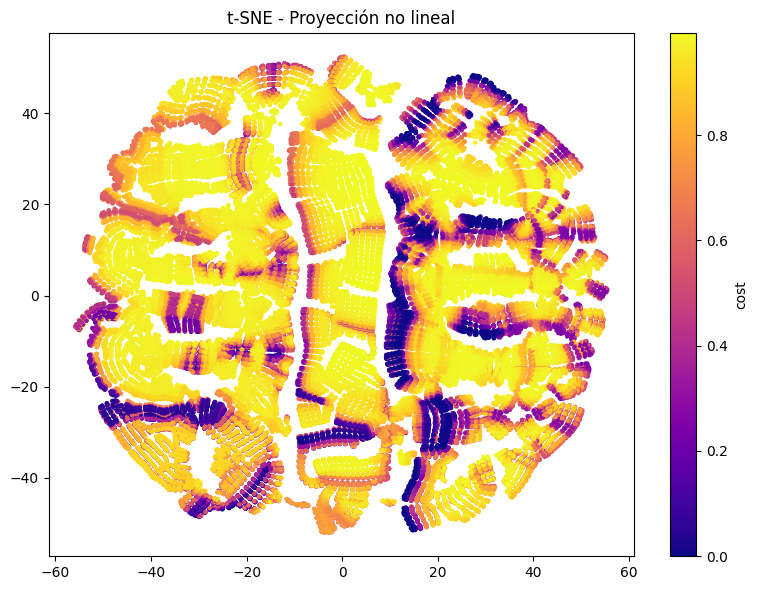

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="plasma", s=5)
plt.colorbar(sc, label="cost")
plt.title("t-SNE - Proyección no lineal")
plt.tight_layout()
plt.show()


# param0 = 0.5, param1 = 0.5

AR medio maximo: 0.9861200094464424 , Parámetros: [0.79 0.5  1.   0.5 ]


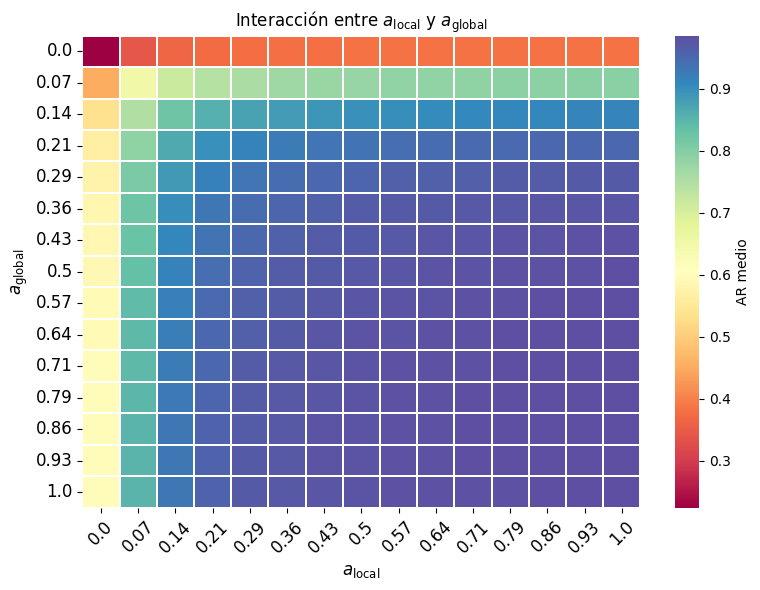

In [16]:
df_filtrado = df_rounded[(df_rounded['param1'] == 0.5) & (df_rounded['param3'] == 0.5)]
print('AR medio maximo:', df_filtrado.cost.max(), ', Parámetros:', df_filtrado[df_filtrado['cost'] == df_filtrado['cost'].max()][["param0", "param1", "param2", "param3"]].values[0])

# Graficar un mapa de calor para cada combinación
x_param = "param2"
y_param = "param0"
pivot_table = df_filtrado.pivot_table(values="cost", index=y_param, columns=x_param, aggfunc="mean")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap="Spectral" , cbar_kws={"label": "AR medio"}, linewidths=0.1)
plt.title(f"Interacción entre {nombres[x_param]} y {nombres[y_param]}")
plt.xlabel(nombres[x_param], fontsize=12)
plt.ylabel(nombres[y_param], fontsize=12)
# Aumentar el tamaño de las etiquetas
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
